In [1]:
 !pip install trl -q
 !pip install transformers -q
 !pip install vllm -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 335.7/335.7 kB 5.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.6/293.6 MB 5.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 64.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 85.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 MB 37.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 86.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s e

In [4]:
import os
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import wandb
import torch.nn.functional as F

from typing import List
from dataclasses import dataclass

from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel
from trl import DataCollatorForCompletionOnlyLM, OnlineDPOConfig, DPOConfig, OnlineDPOTrainer, DPOTrainer, FDivergenceType, FDivergenceConstants
from vllm import LLM, SamplingParams

In [6]:
@dataclass
class Config:
  seed: int = 42
  dataset_path: str = 'HuggingFaceH4/ultrafeedback_binarized'
  model_name: str = 'HuggingFaceTB/SmolLM-135M-Instruct'

  pair_rm_model: str = "llm-blender/PairRM"
  eval_size: int = 100

  temperature: float = 0.2
  top_p: float = 0.95


  max_seq_len: int = 1024

  output_dir: str = "/kaggle/working/trained_dpo"
  eval_steps: int = 10
  gradient_accumulation_steps: int = 4
  gradient_checkpointing: bool = True
  batch_size: int = 4
  max_prompt_length: int = 128
  max_completion_length: int = 256
  max_steps: int = 200
  lr_scheduler_type: str = "cosine" 
  learning_rate: int = 5e-5
  logging_steps: int = 10
  bf16: bool = True # try on P100
  fp16: bool = False
  tf32: bool = False
  beta: float = 5
  #beta = {0.1, 0.05, 1, 5} in paper

  max_tokens_output: int = 768

  def __post_init__(self):
    self.num_proc = os.cpu_count() // torch.cuda.device_count() if torch.cuda.is_available() else 1
    self.model_rlhf = "/kaggle/input/trained-dpo-beta-01-2v/kaggle/working/trained_dpo_beta_0.1"

config = Config()
# print(config.num_proc)

In [4]:
def seed_env(seed: int = Config.seed) -> None:
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)

def seed_torch(seed: int = Config.seed) -> None:
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

def seed_everything() -> None:
  """Set seeds"""
  seed_torch()
  seed_env()

def init_wandb() -> None:
  wandb.login(key="abc76743c2934682510c9f2cf81c1896709fe072")
  wandb.init(project='DPO, HW2', entity='lulim')

seed_everything()
init_wandb()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: lulim (turbo-alignment). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: lulim. Use `wandb login --relogin` to force relogin


In [3]:
def filter_dataset(sample: Dataset) -> bool:
    tokenizer = AutoTokenizer.from_pretrained(
        config.model_name,
        padding="right",
        truncation_side="right",
        use_fast=True,
        model_max_length=config.max_seq_len
    )

    
    def len_filter(sample: Dataset) -> bool:
        chosen_conversation = sample["chosen"]
        tokenized_chosen = tokenizer.apply_chat_template(
            conversation=chosen_conversation,
            add_generation_prompt=False,
            tokenize=True,
            truncation=False,
            return_dict=True
        )

        rejected_conversation = sample["rejected"]
        tokenized_rejected = tokenizer.apply_chat_template(
            conversation=chosen_conversation,
            add_generation_prompt=False,
            tokenize=True,
            truncation=False,
            return_dict=True
        )
        return (len(tokenized_chosen["input_ids"]) <= config.max_seq_len) and (len(tokenized_rejected["input_ids"]) <= config.max_seq_len)
    return len_filter(sample)

In [14]:
ds = load_dataset(config.dataset_path)
ds["train_prefs"] = ds["train_prefs"].select(range(1000)).filter(filter_dataset, batched=False, num_proc=config.num_proc).shuffle(seed=config.seed)
ds["test_prefs"] = ds["test_prefs"].select(range(1000)).filter(filter_dataset, batched=False, num_proc=config.num_proc).shuffle(seed=config.seed)
ds


In [4]:
model = AutoModelForCausalLM.from_pretrained(
    config.model_name,
    torch_dtype=torch.bfloat16
)
tokenizer = AutoTokenizer.from_pretrained(
        config.model_name,
        padding="right",
        truncation_side="right",
        use_fast=True,
        model_max_length=config.max_seq_len
)
tokenizer.pad_token = tokenizer.eos_token

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/269M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.59k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/801k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

## Vanila DPO

In [10]:
config.output_dir = config.output_dir + f"_beta_{config.beta}"
config.output_dir

'/kaggle/working/trained_dpo_beta_5'

In [11]:
training_args = DPOConfig(
    output_dir=config.output_dir,
    eval_strategy="steps",
    eval_steps=config.eval_steps,
    # report_to="wandb",
    report_to="none",
    gradient_accumulation_steps=config.gradient_accumulation_steps,
    gradient_checkpointing=config.gradient_checkpointing,
    per_device_train_batch_size=config.batch_size,
    per_device_eval_batch_size=config.batch_size,
    max_prompt_length=config.max_prompt_length,
    max_completion_length=config.max_completion_length,
    max_steps=config.max_steps,
    lr_scheduler_type=config.lr_scheduler_type,
    learning_rate=config.learning_rate,
    logging_steps=config.logging_steps,
    beta=config.beta,
    fp16=config.fp16,
    tf32=config.tf32,
    bf16=config.bf16
)
dpo_trainer = DPOTrainer(
    model=model,
    processing_class=tokenizer,
    args=training_args,
    train_dataset=ds["train_prefs"].select_columns(["prompt", "chosen", "rejected"]),
    eval_dataset=ds["test_prefs"].select_columns(["prompt", "chosen", "rejected"])
)
dpo_trainer.train()
dpo_trainer.save_model()

Extracting prompt in train dataset:   0%|          | 0/934 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/934 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/934 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1036 > 1024). Running this sequence through the model will result in indexing errors


Extracting prompt in eval dataset:   0%|          | 0/932 [00:00<?, ? examples/s]

Applying chat template to eval dataset:   0%|          | 0/932 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/932 [00:00<?, ? examples/s]

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss,Validation Loss,Rewards/chosen,Rewards/rejected,Rewards/accuracies,Rewards/margins,Logps/chosen,Logps/rejected,Logits/chosen,Logits/rejected
10,1.831900,2.126009,-1.241936,-1.773510,0.542918,0.531574,-295.413422,-289.308014,-0.505283,-0.338918
20,1.586400,2.143726,-0.537510,-1.217720,0.531116,0.680210,-295.272522,-289.196808,-0.479461,-0.313732
30,2.168700,2.167031,0.418590,-0.230132,0.547210,0.648721,-295.081299,-288.999298,-0.459458,-0.293470
40,2.179700,2.164281,0.700673,0.172875,0.520386,0.527798,-295.024902,-288.918701,-0.448208,-0.282238
50,1.827200,2.067701,0.981626,0.299071,0.543991,0.682554,-294.968719,-288.893463,-0.451606,-0.285932
60,1.873200,1.960009,0.628709,-0.262658,0.548283,0.891367,-295.039337,-289.005829,-0.462894,-0.297051
70,0.329900,2.125365,0.248159,-0.383990,0.545064,0.632149,-295.115417,-289.030090,-0.467956,-0.301630
80,0.547700,2.121719,0.374749,-0.416980,0.555794,0.791729,-295.090057,-289.036682,-0.471225,-0.305130
90,0.360200,1.952107,0.306544,-0.715746,0.550429,1.022291,-295.103729,-289.096405,-0.464510,-0.298507
100,0.508800,2.127689,0.101115,-0.648776,0.541846,0.749890,-295.144806,-289.083008,-0.470504,-0.305494


# Pair eval

In [4]:
!pip install git+https://github.com/yuchenlin/LLM-Blender.git -q

  Preparing metadata (setup.py) ... done


In [7]:
import llm_blender
from llm_blender.pair_ranker.pairrm import DebertaV2PairRM

pair_rm = llm_blender.Blender()
pair_rm.loadranker(config.pair_rm_model)

ds = load_dataset(config.dataset_path)
np.random.seed(config.seed)
eval_idxs = np.random.randint(low=0, high=len(ds), size=config.eval_size)
# print(f"{eval_idxs}")
ds_eval = ds["test_sft"].select(eval_idxs).select_columns(["prompt"]).shuffle(seed=config.seed)
ds_eval = [sample["prompt"] for sample in ds_eval]
ds_eval[0]

Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

README.md:   0%|          | 0.00/13.7k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

ranker_config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/130 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.66M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.00k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.79k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/dataclasses_json/core.py:201: RuntimeWarning: 'NoneType' object value of non-optional type load_checkpoint detected when decoding RankerConfig.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/dataclasses_json/core.py:201: RuntimeWarning: 'NoneType' object value of non-optional type device detected when decoding RankerConfig.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/580 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/874M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/874M [00:00<?, ?B/s]

Successfully loaded ranker from  /root/.cache/huggingface/hub/llm-blender/PairRM


README.md:   0%|          | 0.00/6.53k [00:00<?, ?B/s]

train_prefs-00000-of-00001.parquet:   0%|          | 0.00/226M [00:00<?, ?B/s]

test_prefs-00000-of-00001.parquet:   0%|          | 0.00/7.29M [00:00<?, ?B/s]

test_sft-00000-of-00001.parquet:   0%|          | 0.00/3.72M [00:00<?, ?B/s]

train_gen-00000-of-00001.parquet:   0%|          | 0.00/184M [00:00<?, ?B/s]

test_gen-00000-of-00001.parquet:   0%|          | 0.00/3.02M [00:00<?, ?B/s]

Generating train_prefs split:   0%|          | 0/61135 [00:00<?, ? examples/s]

Generating train_sft split:   0%|          | 0/61135 [00:00<?, ? examples/s]

Generating test_prefs split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test_sft split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating train_gen split:   0%|          | 0/61135 [00:00<?, ? examples/s]

Generating test_gen split:   0%|          | 0/1000 [00:00<?, ? examples/s]

'Evaluate the extent to which web usability is affected by various design styles, including color scheme, typography, layout, and navigation. Provide specific examples and empirical evidence to support your analysis.'

In [8]:
def give_text_answers(prompts, pair_rm_model, model_sft, model_rlhf, sampling_params):
  model_sft = LLM(model=model_sft, dtype="float16", gpu_memory_utilization=0.4)
  model_rlhf = LLM(model=model_rlhf, dtype="float16", gpu_memory_utilization=0.4)

  outputs_sft = model_sft.generate(prompts, sampling_params)
  outputs_rlhf = model_rlhf.generate(prompts, sampling_params)

  only_outputs_sft = [output.outputs[0].text for output in outputs_sft]
  only_outputs_rlhf = [output.outputs[0].text for output in outputs_rlhf]
 
  only_outputs_sft_logprobs = [output.outputs[0].logprobs for output in outputs_sft]
  only_outputs_rlhf_logprobs = [output.outputs[0].logprobs for output in outputs_rlhf]
  # print(outputs_rlhf)
  comparison_results = pair_rm_model.compare(prompts, only_outputs_rlhf, only_outputs_sft, 
                                             batch_size=2) # A > B

  return comparison_results, only_outputs_rlhf, only_outputs_sft, \
        only_outputs_rlhf_logprobs, only_outputs_sft_logprobs

In [9]:
def get_logprob(vllm_outputs):
    logprobs = [output for output in vllm_outputs[0]]
    logprobs = [[value for key, value in item.items()] for item in logprobs]
    logprobs = [logprob[0].logprob for logprob in logprobs]
    return logprobs
    

In [10]:
def get_win_rate_kl(model_path, sft_model, pair_rm):
    sampling_params = SamplingParams(temperature=config.temperature, top_p=config.top_p,
                                 max_tokens=config.max_tokens_output, 
                                 logprobs=20
    )
    comparison_results, outputs_rlhf, outputs_sft, only_outputs_rlhf_logprobs, only_outputs_sft_logprobs = give_text_answers(ds_eval, pair_rm, config.model_name, model_path, sampling_params)
    model_logprobs = np.array(get_logprob(only_outputs_rlhf_logprobs))
    sft_logprobs = np.array(get_logprob(only_outputs_sft_logprobs))
    min_len = min(len(model_logprobs), len(sft_logprobs))
    model_kl = np.mean(model_logprobs[-min_len:] - sft_logprobs[-min_len:])

    win_rate = comparison_results.sum() / comparison_results.shape[0]
    return {"model_path": model_path, "win_rate": win_rate, "kl": model_kl}

# BEYOND REVERSE KL DIVERGANCE

In [ ]:
class DPOForwardKL(DPOTrainer):
    def __init__(self, model, processing_class, args, train_dataset, eval_dataset):
        self.model = model
        self.processing_class = processing_class
        self.train_dataset = train_dataset
        self.eval_dataset = eval_dataset
        self.eps = 1e-5
        super().__init__(model=model, processing_class=processing_class,
                         args=args, train_dataset=train_dataset, eval_dataset=eval_dataset)

    def custom_func_derivative(self, x: float) -> torch.tensor:
        # print(f"arg: {x}")
        return -torch.pow(x + self.eps, -1)

    def dpo_loss(
        self,
        chosen_logps: torch.FloatTensor,
        rejected_logps: torch.FloatTensor,
        ref_chosen_logps: torch.FloatTensor,
        ref_rejected_logps: torch.FloatTensor,
    ) -> tuple[torch.FloatTensor, torch.FloatTensor, torch.FloatTensor]:
        """
        Compute the DPO loss for a batch of policy and reference model log probabilities.

        Args:
                Log probabilities of the model for the chosen responses. Shape: `(batch_size,)`.
            rejected_logps (`torch.FloatTensor`):
                Log probabilities of the model for the rejected responses. Shape: `(batch_size,)`.
            ref_chosen_logps (`torch.FloatTensor`):
                Log probabilities of the reference model for the chosen responses. Shape: `(batch_size,)`.
            ref_rejected_logps (`torch.FloatTensor`):
                Log probabilities of the reference model for the rejected responses. Shape: `(batch_size,)`.

        Returns:
            A tuple of three tensors: `(losses, chosen_rewards, rejected_rewards)`.
            The losses tensor contains the DPO loss for each example in the batch.
            The `chosen_rewards` and `rejected_rewards` tensors contain the rewards for the chosen and rejected
            responses, respectively.
        """
        # print(f"calc dpo loss")
        # print(f"chosen_logps: {chosen_logps}")
        # print(f"rejected_logps: {rejected_logps}")
        # print(f"ref_chosen_logps: {ref_chosen_logps}")
        # print(f"ref_rejected_logps: {ref_rejected_logps}")
        device = self.accelerator.device
        chosen_logratios = chosen_logps.to(device) - (not self.reference_free) * ref_chosen_logps.to(device)
        rejected_logratios = rejected_logps.to(device) - (not self.reference_free) * ref_rejected_logps.to(device)

        # print(f"chosen_logratios: {chosen_logratios}")
        # print(f"rejected_logratios: {rejected_logratios}")
        if self.f_divergence_type == FDivergenceType.ALPHA_DIVERGENCE.value:
            # The alpha-divergence formula: (1 - u^-alpha) / alpha
            # The divergence difference between the chosen and rejected sample is:
            #     (1 - u[w]^-alpha) / alpha - (1 - u[l]^-alpha) / alpha
            #        = (u[l]^-alpha - u[w]^-alpha) / alpha
            # where u[w] and u[l] are the policy/reference probability ratios
            # for the chosen and rejected samples, respectively.
            alpha_coef = FDivergenceConstants.ALPHA_DIVERGENCE_COEF_DEFAULT
            if self.f_divergence_params and FDivergenceConstants.ALPHA_DIVERGENCE_COEF_KEY in self.f_divergence_params:
                alpha_coef = float(self.f_divergence_params[FDivergenceConstants.ALPHA_DIVERGENCE_COEF_KEY])
            logits = (cap_exp(rejected_logratios * -alpha_coef) - cap_exp(chosen_logratios * -alpha_coef)) / alpha_coef
        else:
            logratios = chosen_logps - rejected_logps
            if self.reference_free:
                ref_logratios = torch.tensor([0], dtype=logratios.dtype, device=logratios.device)
            else:
                ref_logratios = ref_chosen_logps - ref_rejected_logps

            logratios = logratios.to(self.accelerator.device)
            ref_logratios = ref_logratios.to(self.accelerator.device)
            logits = logratios - ref_logratios

            if self.f_divergence_type == FDivergenceType.JS_DIVERGENCE.value:
                # The js-divergence formula: log(2 * u / (1 + u))
                # The divergence difference between the chosen and rejected sample is:
                #     log(2 * u[w] / (1 + u[w])) - log(2 * u[l] / (1 + u[l]))
                #       = log(u[w]) - log(u[l]) - (log(1 + u[w]) - log(1 + u[l]))
                # where u[w] and u[l] are the policy/reference probability ratios
                # for the chosen and rejected samples, respectively.
                logits -= F.softplus(chosen_logratios) - F.softplus(rejected_logratios)
        losses = (- F.logsigmoid(self.beta * self.custom_func_derivative(chosen_logratios) - \
                    self.beta * self.custom_func_derivative(rejected_logratios)))
        # print(f"losses: {losses}")
        # print(f"beta: {self.beta}")
        chosen_rewards = self.beta * (chosen_logps.to(device) - ref_chosen_logps.to(device)).detach()
        rejected_rewards = self.beta * (rejected_logps.to(device) - ref_rejected_logps.to(device)).detach()
        # print(f"{losses}, {chosen_rewards}, {rejected_rewards}")
        return losses, chosen_rewards, rejected_rewards

In [11]:
class DPOReverseKL(DPOTrainer):
    def __init__(self, model, processing_class, args, train_dataset, eval_dataset):
        self.model = model
        self.processing_class = processing_class
        self.train_dataset = train_dataset
        self.eval_dataset = eval_dataset
        self.eps = 1e-5
        super().__init__(model=model, processing_class=processing_class,
                         args=args, train_dataset=train_dataset, eval_dataset=eval_dataset)

    def custom_func_derivative(self, x: torch.tensor) -> torch.tensor:
        x = F.softplus(x)
        return torch.log(x + self.eps) + 1

    def dpo_loss(
        self,
        chosen_logps: torch.FloatTensor,
        rejected_logps: torch.FloatTensor,
        ref_chosen_logps: torch.FloatTensor,
        ref_rejected_logps: torch.FloatTensor,
    ) -> tuple[torch.FloatTensor, torch.FloatTensor, torch.FloatTensor]:
        """
        Compute the DPO loss for a batch of policy and reference model log probabilities.

        Args:
            chosen_logps (`torch.FloatTensor`):
                Log probabilities of the model for the chosen responses. Shape: `(batch_size,)`.
            rejected_logps (`torch.FloatTensor`):
                Log probabilities of the model for the rejected responses. Shape: `(batch_size,)`.
            ref_chosen_logps (`torch.FloatTensor`):
                Log probabilities of the reference model for the chosen responses. Shape: `(batch_size,)`.
            ref_rejected_logps (`torch.FloatTensor`):
                Log probabilities of the reference model for the rejected responses. Shape: `(batch_size,)`.

        Returns:
            A tuple of three tensors: `(losses, chosen_rewards, rejected_rewards)`.
            The losses tensor contains the DPO loss for each example in the batch.
            The `chosen_rewards` and `rejected_rewards` tensors contain the rewards for the chosen and rejected
            responses, respectively.
        """
        # print(f"calc dpo loss")
        device = self.accelerator.device
        # print(f"chosen_logps: {chosen_logps}, ref_chosen_logps: {ref_chosen_logps}")
        # print(f"rejected_logps: {rejected_logps}, ref_rejected_logps: {ref_rejected_logps}")
        chosen_logratios = chosen_logps.to(device) - (not self.reference_free) * ref_chosen_logps.to(device)
        rejected_logratios = rejected_logps.to(device) - (not self.reference_free) * ref_rejected_logps.to(device)

        # print(f"chosen_logratios: {chosen_logratios}")
        # print(f"rejected_logratios: {rejected_logratios}")
        if self.f_divergence_type == FDivergenceType.ALPHA_DIVERGENCE.value:
            # The alpha-divergence formula: (1 - u^-alpha) / alpha
            # The divergence difference between the chosen and rejected sample is:
            #     (1 - u[w]^-alpha) / alpha - (1 - u[l]^-alpha) / alpha
            #        = (u[l]^-alpha - u[w]^-alpha) / alpha
            # where u[w] and u[l] are the policy/reference probability ratios
            # for the chosen and rejected samples, respectively.
            alpha_coef = FDivergenceConstants.ALPHA_DIVERGENCE_COEF_DEFAULT
            if self.f_divergence_params and FDivergenceConstants.ALPHA_DIVERGENCE_COEF_KEY in self.f_divergence_params:
                alpha_coef = float(self.f_divergence_params[FDivergenceConstants.ALPHA_DIVERGENCE_COEF_KEY])
            logits = (cap_exp(rejected_logratios * -alpha_coef) - cap_exp(chosen_logratios * -alpha_coef)) / alpha_coef
        else:
            logratios = chosen_logps - rejected_logps
            if self.reference_free:
                ref_logratios = torch.tensor([0], dtype=logratios.dtype, device=logratios.device)
            else:
                ref_logratios = ref_chosen_logps - ref_rejected_logps

            logratios = logratios.to(self.accelerator.device)
            ref_logratios = ref_logratios.to(self.accelerator.device)
            logits = logratios - ref_logratios

            if self.f_divergence_type == FDivergenceType.JS_DIVERGENCE.value:
                # The js-divergence formula: log(2 * u / (1 + u))
                # The divergence difference between the chosen and rejected sample is:
                #     log(2 * u[w] / (1 + u[w])) - log(2 * u[l] / (1 + u[l]))
                #       = log(u[w]) - log(u[l]) - (log(1 + u[w]) - log(1 + u[l]))
                # where u[w] and u[l] are the policy/reference probability ratios
                # for the chosen and rejected samples, respectively.
                logits -= F.softplus(chosen_logratios) - F.softplus(rejected_logratios)
        losses = (- F.logsigmoid(self.beta * self.custom_func_derivative(chosen_logratios) - \
                    self.beta * self.custom_func_derivative(rejected_logratios)))
        # print(f"losses: {losses}")

        chosen_rewards = self.beta * (chosen_logps.to(device) - ref_chosen_logps.to(device)).detach()
        rejected_rewards = self.beta * (rejected_logps.to(device) - ref_rejected_logps.to(device)).detach()
        # print(f"{chosen_rewards}, {rejected_rewards}")
        return losses, chosen_rewards, rejected_rewards

In [ ]:
@dataclass
class Config:
  seed: int = 42
  dataset_path: str = 'HuggingFaceH4/ultrafeedback_binarized'
  model_name: str = 'HuggingFaceTB/SmolLM-135M-Instruct'

  pair_rm_model: str = "llm-blender/PairRM"
  eval_size: int = 100

  temperature: float = 0.2
  top_p: float = 0.95


  max_seq_len: int = 1024

  output_dir: str = "/kaggle/working/trained_dpo_forward_kl"
  eval_steps: int = 10
  gradient_accumulation_steps: int = 4
  gradient_checkpointing: bool = True
  batch_size: int = 4
  max_prompt_length: int = 128
  max_completion_length: int = 256
  max_steps: int = 200
  lr_scheduler_type: str = "cosine" 
  learning_rate: int = 5e-5
  logging_steps: int = 10
  bf16: bool = True # try on P100
  fp16: bool = False
  tf32: bool = False
  beta: float = 0.1

  max_tokens_output: int = 768

  def __post_init__(self):
    self.num_proc = os.cpu_count() // torch.cuda.device_count() if torch.cuda.is_available() else 1
    self.model_rlhf = "/kaggle/input/trained-dpo-a-5e-5/kaggle/working/trained_dpo"

forward_kl_config = Config()
forward_kl_config.beta = 0.1
# print(config.num_proc)

In [ ]:
training_args = DPOConfig(
    output_dir=forward_kl_config.output_dir,
    eval_strategy="steps",
    eval_steps=forward_kl_config.eval_steps,
    report_to="wandb",
    # report_to="none",
    gradient_accumulation_steps=forward_kl_config.gradient_accumulation_steps,
    gradient_checkpointing=forward_kl_config.gradient_checkpointing,
    per_device_train_batch_size=forward_kl_config.batch_size,
    per_device_eval_batch_size=forward_kl_config.batch_size,
    max_prompt_length=forward_kl_config.max_prompt_length,
    max_completion_length=forward_kl_config.max_completion_length,
    max_steps=forward_kl_config.max_steps,
    lr_scheduler_type=forward_kl_config.lr_scheduler_type,
    learning_rate=forward_kl_config.learning_rate,
    logging_steps=forward_kl_config.logging_steps,
    beta=forward_kl_config.beta,
    fp16=forward_kl_config.fp16,
    tf32=forward_kl_config.tf32,
    bf16=forward_kl_config.bf16,
    loss_type="forward_kl"
)
forward_dpo_trainer = DPOForwardKL(
    model=model,
    processing_class=tokenizer,
    args=training_args,
    train_dataset=ds["train_prefs"].select_columns(["prompt", "chosen", "rejected"]),
    eval_dataset=ds["test_prefs"].select_columns(["prompt", "chosen", "rejected"])
)
forward_dpo_trainer.train()
forward_dpo_trainer.save_model()

In [9]:
reverse_kl_config = Config()
reverse_kl_config.beta = 0.1
reverse_kl_config.output_dir = "/kaggle/working/trained_dpo_reverse_kl"

In [12]:
training_args = DPOConfig(
    output_dir=reverse_kl_config.output_dir,
    eval_strategy="steps",
    eval_steps=reverse_kl_config.eval_steps,
    report_to="wandb",
    # report_to="none",
    gradient_accumulation_steps=reverse_kl_config.gradient_accumulation_steps,
    gradient_checkpointing=reverse_kl_config.gradient_checkpointing,
    per_device_train_batch_size=reverse_kl_config.batch_size,
    per_device_eval_batch_size=reverse_kl_config.batch_size,
    max_prompt_length=reverse_kl_config.max_prompt_length,
    max_completion_length=reverse_kl_config.max_completion_length,
    max_steps=reverse_kl_config.max_steps,
    lr_scheduler_type=reverse_kl_config.lr_scheduler_type,
    learning_rate=reverse_kl_config.learning_rate,
    logging_steps=reverse_kl_config.logging_steps,
    beta=reverse_kl_config.beta,
    fp16=reverse_kl_config.fp16,
    tf32=reverse_kl_config.tf32,
    bf16=reverse_kl_config.bf16,
    loss_type="reverse_kl"
)
reverse_dpo_trainer = DPOReverseKL(
    model=model,
    processing_class=tokenizer,
    args=training_args,
    train_dataset=ds["train_prefs"].select_columns(["prompt", "chosen", "rejected"]),
    eval_dataset=ds["test_prefs"].select_columns(["prompt", "chosen", "rejected"])
)
reverse_dpo_trainer.train()
reverse_dpo_trainer.save_model()

Extracting prompt in train dataset:   0%|          | 0/934 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/934 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/934 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1036 > 1024). Running this sequence through the model will result in indexing errors


Extracting prompt in eval dataset:   0%|          | 0/932 [00:00<?, ? examples/s]

Applying chat template to eval dataset:   0%|          | 0/932 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/932 [00:00<?, ? examples/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss,Validation Loss,Rewards/chosen,Rewards/rejected,Rewards/accuracies,Rewards/margins,Logps/chosen,Logps/rejected,Logits/chosen,Logits/rejected
10,0.684800,0.687834,-0.068932,-0.085605,0.542918,0.016672,-295.854340,-289.809326,-0.536630,-0.369855
20,0.688900,0.683202,-0.087601,-0.117411,0.557940,0.029810,-296.041046,-290.127380,-0.530776,-0.364754
30,0.678100,0.679506,-0.092928,-0.133583,0.567597,0.040655,-296.094330,-290.289093,-0.521573,-0.355945
40,0.674900,0.677640,-0.104654,-0.151251,0.583691,0.046597,-296.211578,-290.465759,-0.516229,-0.351464
50,0.685500,0.676777,-0.110211,-0.160270,0.584764,0.050059,-296.267120,-290.555969,-0.517217,-0.352834
60,0.622300,0.677001,-0.133105,-0.184919,0.571888,0.051815,-296.496063,-290.802460,-0.534291,-0.370242
70,0.604300,0.674172,-0.160841,-0.221464,0.586910,0.060622,-296.773438,-291.167908,-0.543769,-0.379036
80,0.591500,0.673954,-0.185953,-0.249024,0.565451,0.063071,-297.024567,-291.443512,-0.560539,-0.396896
90,0.588000,0.672208,-0.204645,-0.273968,0.576180,0.069324,-297.211487,-291.692963,-0.566233,-0.402573
100,0.587600,0.671099,-0.215355,-0.287397,0.587983,0.072041,-297.318604,-291.827209,-0.572336,-0.408166


In [8]:
class AlphaDivergence(DPOTrainer):
    def __init__(self, model, processing_class, args, train_dataset, eval_dataset):
        self.model = model
        self.processing_class = processing_class
        self.train_dataset = train_dataset
        self.eval_dataset = eval_dataset
        self.eps = 1e-5
        self.alpha = 0.5
        super().__init__(model=model, processing_class=processing_class,
                         args=args, train_dataset=train_dataset, eval_dataset=eval_dataset)

    def custom_func_derivative(self, x: float) -> torch.tensor:
        # pow with 0 < rate < 1 => x > 0 - domain
        x = F.softplus(x)
        return (1 - torch.pow(x + self.eps, -self.alpha)) / self.alpha

    def dpo_loss(
        self,
        chosen_logps: torch.FloatTensor,
        rejected_logps: torch.FloatTensor,
        ref_chosen_logps: torch.FloatTensor,
        ref_rejected_logps: torch.FloatTensor,
    ) -> tuple[torch.FloatTensor, torch.FloatTensor, torch.FloatTensor]:
        """
        Compute the DPO loss for a batch of policy and reference model log probabilities.

        Args:
            chosen_logps (`torch.FloatTensor`):
                Log probabilities of the model for the chosen responses. Shape: `(batch_size,)`.
            rejected_logps (`torch.FloatTensor`):
                Log probabilities of the model for the rejected responses. Shape: `(batch_size,)`.
            ref_chosen_logps (`torch.FloatTensor`):
                Log probabilities of the reference model for the chosen responses. Shape: `(batch_size,)`.
            ref_rejected_logps (`torch.FloatTensor`):
                Log probabilities of the reference model for the rejected responses. Shape: `(batch_size,)`.

        Returns:
            A tuple of three tensors: `(losses, chosen_rewards, rejected_rewards)`.
            The losses tensor contains the DPO loss for each example in the batch.
            The `chosen_rewards` and `rejected_rewards` tensors contain the rewards for the chosen and rejected
            responses, respectively.
        """
        device = self.accelerator.device
        chosen_logratios = chosen_logps.to(device) - (not self.reference_free) * ref_chosen_logps.to(device)
        rejected_logratios = rejected_logps.to(device) - (not self.reference_free) * ref_rejected_logps.to(device)

        if self.f_divergence_type == FDivergenceType.ALPHA_DIVERGENCE.value:
            # The alpha-divergence formula: (1 - u^-alpha) / alpha
            # The divergence difference between the chosen and rejected sample is:
            #     (1 - u[w]^-alpha) / alpha - (1 - u[l]^-alpha) / alpha
            #        = (u[l]^-alpha - u[w]^-alpha) / alpha
            # where u[w] and u[l] are the policy/reference probability ratios
            # for the chosen and rejected samples, respectively.
            alpha_coef = FDivergenceConstants.ALPHA_DIVERGENCE_COEF_DEFAULT
            if self.f_divergence_params and FDivergenceConstants.ALPHA_DIVERGENCE_COEF_KEY in self.f_divergence_params:
                alpha_coef = float(self.f_divergence_params[FDivergenceConstants.ALPHA_DIVERGENCE_COEF_KEY])
            logits = (cap_exp(rejected_logratios * -alpha_coef) - cap_exp(chosen_logratios * -alpha_coef)) / alpha_coef
        else:
            logratios = chosen_logps - rejected_logps
            if self.reference_free:
                ref_logratios = torch.tensor([0], dtype=logratios.dtype, device=logratios.device)
            else:
                ref_logratios = ref_chosen_logps - ref_rejected_logps

            logratios = logratios.to(self.accelerator.device)
            ref_logratios = ref_logratios.to(self.accelerator.device)
            logits = logratios - ref_logratios

            if self.f_divergence_type == FDivergenceType.JS_DIVERGENCE.value:
                # The js-divergence formula: log(2 * u / (1 + u))
                # The divergence difference between the chosen and rejected sample is:
                #     log(2 * u[w] / (1 + u[w])) - log(2 * u[l] / (1 + u[l]))
                #       = log(u[w]) - log(u[l]) - (log(1 + u[w]) - log(1 + u[l]))
                # where u[w] and u[l] are the policy/reference probability ratios
                # for the chosen and rejected samples, respectively.
                logits -= F.softplus(chosen_logratios) - F.softplus(rejected_logratios)
        losses = (- F.logsigmoid(self.beta * self.custom_func_derivative(chosen_logratios) - \
                    self.beta * self.custom_func_derivative(rejected_logratios)))

        chosen_rewards = self.beta * (chosen_logps.to(device) - ref_chosen_logps.to(device)).detach()
        rejected_rewards = self.beta * (rejected_logps.to(device) - ref_rejected_logps.to(device)).detach()
        return losses, chosen_rewards, rejected_rewards

In [16]:
class JSDivergence(DPOTrainer):
    def __init__(self, model, processing_class, args, train_dataset, eval_dataset):
        self.model = model
        self.processing_class = processing_class
        self.train_dataset = train_dataset
        self.eval_dataset = eval_dataset
        self.eps = 1e-5
        super().__init__(model=model, processing_class=processing_class,
                         args=args, train_dataset=train_dataset, eval_dataset=eval_dataset)

    def custom_func_derivative(self, x: float) -> torch.tensor:
        # print(f"arg: {x}")
        # log: domain > 0
        x = F.softplus(2 * x / (1 + x))
        return torch.log(x + self.eps)

    def dpo_loss(
        self,
        chosen_logps: torch.FloatTensor,
        rejected_logps: torch.FloatTensor,
        ref_chosen_logps: torch.FloatTensor,
        ref_rejected_logps: torch.FloatTensor,
    ) -> tuple[torch.FloatTensor, torch.FloatTensor, torch.FloatTensor]:
        """
        Compute the DPO loss for a batch of policy and reference model log probabilities.

        Args:
            chosen_logps (`torch.FloatTensor`):
                Log probabilities of the model for the chosen responses. Shape: `(batch_size,)`.
            rejected_logps (`torch.FloatTensor`):
                Log probabilities of the model for the rejected responses. Shape: `(batch_size,)`.
            ref_chosen_logps (`torch.FloatTensor`):
                Log probabilities of the reference model for the chosen responses. Shape: `(batch_size,)`.
            ref_rejected_logps (`torch.FloatTensor`):
                Log probabilities of the reference model for the rejected responses. Shape: `(batch_size,)`.

        Returns:
            A tuple of three tensors: `(losses, chosen_rewards, rejected_rewards)`.
            The losses tensor contains the DPO loss for each example in the batch.
            The `chosen_rewards` and `rejected_rewards` tensors contain the rewards for the chosen and rejected
            responses, respectively.
        """
        # print(f"calc dpo loss")
        device = self.accelerator.device
        # print(f"device: {device}")
        chosen_logratios = chosen_logps.to(device) - (not self.reference_free) * ref_chosen_logps.to(device)
        rejected_logratios = rejected_logps.to(device) - (not self.reference_free) * ref_rejected_logps.to(device)

        # print(f"chosen_logratios: {chosen_logratios}")
        # print(f"rejected_logratios: {rejected_logratios}")
        if self.f_divergence_type == FDivergenceType.ALPHA_DIVERGENCE.value:
            # The alpha-divergence formula: (1 - u^-alpha) / alpha
            # The divergence difference between the chosen and rejected sample is:
            #     (1 - u[w]^-alpha) / alpha - (1 - u[l]^-alpha) / alpha
            #        = (u[l]^-alpha - u[w]^-alpha) / alpha
            # where u[w] and u[l] are the policy/reference probability ratios
            # for the chosen and rejected samples, respectively.
            alpha_coef = FDivergenceConstants.ALPHA_DIVERGENCE_COEF_DEFAULT
            if self.f_divergence_params and FDivergenceConstants.ALPHA_DIVERGENCE_COEF_KEY in self.f_divergence_params:
                alpha_coef = float(self.f_divergence_params[FDivergenceConstants.ALPHA_DIVERGENCE_COEF_KEY])
            logits = (cap_exp(rejected_logratios * -alpha_coef) - cap_exp(chosen_logratios * -alpha_coef)) / alpha_coef
        else:
            logratios = chosen_logps - rejected_logps
            if self.reference_free:
                ref_logratios = torch.tensor([0], dtype=logratios.dtype, device=logratios.device)
            else:
                ref_logratios = ref_chosen_logps - ref_rejected_logps

            logratios = logratios.to(self.accelerator.device)
            ref_logratios = ref_logratios.to(self.accelerator.device)
            logits = logratios - ref_logratios

            if self.f_divergence_type == FDivergenceType.JS_DIVERGENCE.value:
                # The js-divergence formula: log(2 * u / (1 + u))
                # The divergence difference between the chosen and rejected sample is:
                #     log(2 * u[w] / (1 + u[w])) - log(2 * u[l] / (1 + u[l]))
                #       = log(u[w]) - log(u[l]) - (log(1 + u[w]) - log(1 + u[l]))
                # where u[w] and u[l] are the policy/reference probability ratios
                # for the chosen and rejected samples, respectively.
                logits -= F.softplus(chosen_logratios) - F.softplus(rejected_logratios)
        losses = (- F.logsigmoid(self.beta * self.custom_func_derivative(chosen_logratios) - \
                    self.beta * self.custom_func_derivative(rejected_logratios)))
        # print(f"losses: {losses}")

        chosen_rewards = self.beta * (chosen_logps.to(device) - ref_chosen_logps.to(device)).detach()
        rejected_rewards = self.beta * (rejected_logps.to(device) - ref_rejected_logps.to(device)).detach()
        # print(f"{chosen_rewards}, {rejected_rewards}")
        return losses, chosen_rewards, rejected_rewards

In [9]:
alpha_kl_config = Config()
alpha_kl_config.beta = 0.1
alpha_kl_config.output_dir = "/kaggle/working/trained_dpo_alpha_kl"

In [ ]:
training_args = DPOConfig(
    output_dir=alpha_kl_config.output_dir,
    eval_strategy="steps",
    eval_steps=alpha_kl_config.eval_steps,
    report_to="wandb",
    # report_to="none",
    gradient_accumulation_steps=alpha_kl_config.gradient_accumulation_steps,
    gradient_checkpointing=alpha_kl_config.gradient_checkpointing,
    per_device_train_batch_size=alpha_kl_config.batch_size,
    per_device_eval_batch_size=alpha_kl_config.batch_size,
    max_prompt_length=alpha_kl_config.max_prompt_length,
    max_completion_length=alpha_kl_config.max_completion_length,
    max_steps=alpha_kl_config.max_steps,
    lr_scheduler_type=alpha_kl_config.lr_scheduler_type,
    learning_rate=alpha_kl_config.learning_rate,
    logging_steps=alpha_kl_config.logging_steps,
    beta=alpha_kl_config.beta,
    fp16=alpha_kl_config.fp16,
    tf32=alpha_kl_config.tf32,
    bf16=alpha_kl_config.bf16,
    loss_type="alpha_kl"
)
alpha_dpo_trainer = AlphaDivergence(
    model=model,
    processing_class=tokenizer,
    args=training_args,
    train_dataset=ds["train_prefs"].select_columns(["prompt", "chosen", "rejected"]),
    eval_dataset=ds["test_prefs"].select_columns(["prompt", "chosen", "rejected"])
)
alpha_dpo_trainer.train()
alpha_dpo_trainer.save_model()

Extracting prompt in train dataset:   0%|          | 0/934 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/934 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/934 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1036 > 1024). Running this sequence through the model will result in indexing errors


Extracting prompt in eval dataset:   0%|          | 0/932 [00:00<?, ? examples/s]

Applying chat template to eval dataset:   0%|          | 0/932 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/932 [00:00<?, ? examples/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss,Validation Loss,Rewards/chosen,Rewards/rejected,Rewards/accuracies,Rewards/margins,Logps/chosen,Logps/rejected,Logits/chosen,Logits/rejected
10,0.686100,0.686631,-0.071496,-0.089563,0.534335,0.018067,-295.880005,-289.848907,-0.538522,-0.371807


In [15]:
js_kl_config = Config()
js_kl_config.beta = 0.1
js_kl_config.output_dir = "/kaggle/working/trained_dpo_js_kl"

In [20]:
training_args = DPOConfig(
    output_dir=js_kl_config.output_dir,
    eval_strategy="steps",
    eval_steps=js_kl_config.eval_steps,
    report_to="wandb",
    # report_to="none",
    gradient_accumulation_steps=js_kl_config.gradient_accumulation_steps,
    gradient_checkpointing=js_kl_config.gradient_checkpointing,
    per_device_train_batch_size=js_kl_config.batch_size,
    per_device_eval_batch_size=js_kl_config.batch_size,
    max_prompt_length=js_kl_config.max_prompt_length,
    max_completion_length=js_kl_config.max_completion_length,
    max_steps=js_kl_config.max_steps,
    lr_scheduler_type=js_kl_config.lr_scheduler_type,
    learning_rate=js_kl_config.learning_rate,
    logging_steps=js_kl_config.logging_steps,
    beta=js_kl_config.beta,
    fp16=js_kl_config.fp16,
    tf32=js_kl_config.tf32,
    bf16=js_kl_config.bf16,
    loss_type="js_kl"
)
js_dpo_trainer = JSDivergence(
    model=model,
    processing_class=tokenizer,
    args=training_args,
    train_dataset=ds["train_prefs"].select_columns(["prompt", "chosen", "rejected"]),
    eval_dataset=ds["test_prefs"].select_columns(["prompt", "chosen", "rejected"])
)
js_dpo_trainer.train()
js_dpo_trainer.save_model()

Applying chat template to eval dataset:   0%|          | 0/932 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/932 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1059 > 1024). Running this sequence through the model will result in indexing errors


Step,Training Loss,Validation Loss,Rewards/chosen,Rewards/rejected,Rewards/accuracies,Rewards/margins,Logps/chosen,Logps/rejected,Logits/chosen,Logits/rejected
10,0.714100,0.735056,-0.097483,-0.115338,0.533262,0.017855,-296.139862,-290.106659,-0.559159,-0.392593
20,0.725300,0.719982,-0.111158,-0.130998,0.536481,0.019840,-296.276581,-290.263245,-0.568547,-0.402633
30,0.734400,0.726930,-0.087303,-0.107320,0.541846,0.020018,-296.038055,-290.026489,-0.557687,-0.392267
40,0.710400,0.715051,-0.074721,-0.095524,0.543991,0.020803,-295.912262,-289.908508,-0.546171,-0.380089
50,0.702200,0.724574,-0.057147,-0.086139,0.571888,0.028992,-295.736481,-289.814667,-0.530055,-0.364650
60,0.666000,0.730312,-0.057353,-0.086081,0.578326,0.028728,-295.738525,-289.814087,-0.526059,-0.360249
70,0.718400,0.719466,-0.061785,-0.088576,0.552575,0.026792,-295.782898,-289.839020,-0.523502,-0.358059
80,0.724800,0.726447,-0.051547,-0.082127,0.567597,0.030580,-295.680511,-289.774536,-0.519247,-0.353434
90,0.723800,0.722084,-0.047250,-0.073177,0.560086,0.025927,-295.637543,-289.685059,-0.515074,-0.349967
100,0.709300,0.716559,-0.045040,-0.071376,0.577253,0.026337,-295.615417,-289.667053,-0.513197,-0.347867


In [21]:
result_dpo_01 = get_win_rate_kl("/kaggle/input/trained-dpo-beta-01-2v/kaggle/working/trained_dpo_beta_0.1",
                               config.model_name,
                               pair_rm)
result_dpo_01
# {'model_path': '/kaggle/input/trained-dpo-beta-01-2v/kaggle/working/trained_dpo_beta_0.1',
#  'win_rate': 0.43,
#  'kl': 0.002710602007052546}

0.002710602007052546

In [13]:
result_dpo_005 = get_win_rate_kl("/kaggle/input/trained-dpo-beta-005/kaggle/working/trained_dpo_beta_0.05",
                               config.model_name,
                               pair_rm)
result_dpo_005
# {'model_path': '/kaggle/input/trained-dpo-beta-005/kaggle/working/trained_dpo_beta_0.05',
#  'win_rate': 0.56,
#  'kl': 0.04896892805607254}

0.04896892805607254

In [15]:
result_dpo_forward = get_win_rate_kl("/kaggle/input/trained-dpo-forward-kl/kaggle/working/trained_dpo_forward_kl",
                               config.model_name,
                               pair_rm)
result_dpo_forward

# {'model_path': '/kaggle/input/trained-dpo-forward-kl/kaggle/working/trained_dpo_forward_kl',
#  'win_rate': 0.44,
#  'kl': 0.030309515614999075}

0.030309515614999075

In [14]:
result_dpo_alpha = get_win_rate_kl("/kaggle/input/trained-dpo-alpha-kl/kaggle/working/trained_dpo_alpha_kl",
                               config.model_name,
                               pair_rm)
result_dpo_alpha
# {'model_path': '/kaggle/input/trained-dpo-alpha-kl/kaggle/working/trained_dpo_alpha_kl',
#  'win_rate': 0.48,
#  'kl': 0.0024853961410821208}

0.0024853961410821208

In [13]:
js_dpo_kl = get_win_rate_kl("/kaggle/input/trained-dpo-js-kl/kaggle/working/trained_dpo_js_kl",
                               config.model_name,
                               pair_rm)
js_dpo_kl
# {'model_path': '/kaggle/input/trained-dpo-alpha-kl/kaggle/working/trained_dpo_alpha_kl',
#  'win_rate': 0.46,
#  'kl': 0.04253796548823935}

0.04253796548823935

In [13]:
reverse_dpo_kl = get_win_rate_kl("/kaggle/input/trained-dpo-reverse-kl-2/kaggle/working/trained_dpo_reverse_kl",
                               config.model_name,
                               pair_rm)
reverse_dpo_kl
# {'model_path': '/kaggle/input/trained-dpo-reverse-kl-2/kaggle/working/trained_dpo_reverse_kl',
#  'win_rate': 0.57,
#  'kl': 0.05763289394232595}

0.05763289394232595

In [16]:
result_dpo_1 = get_win_rate_kl("/kaggle/input/trained-dpo-beta-1-v2/kaggle/working/trained_dpo_beta_1",
                               config.model_name,
                               pair_rm)
result_dpo_1
# {'model_path': '/kaggle/input/trained-dpo-beta-1-v2/kaggle/working/trained_dpo_beta_1',
#  'win_rate': 0.51,
#  'kl': 0.025874380103271942}

0.025874380103271942

In [18]:
result_dpo_5 = get_win_rate_kl("/kaggle/input/trained-dpo-beta-5-v2/kaggle/working/trained_dpo_beta_5",
                               config.model_name,
                               pair_rm)
result_dpo_5

# {'model_path': '/kaggle/input/trained-dpo-beta-5-v2/kaggle/working/trained_dpo_beta_5',
#  'win_rate': 0.46,
#  'kl': 0.04169781367572677}

0.04169781367572677

# Result plots

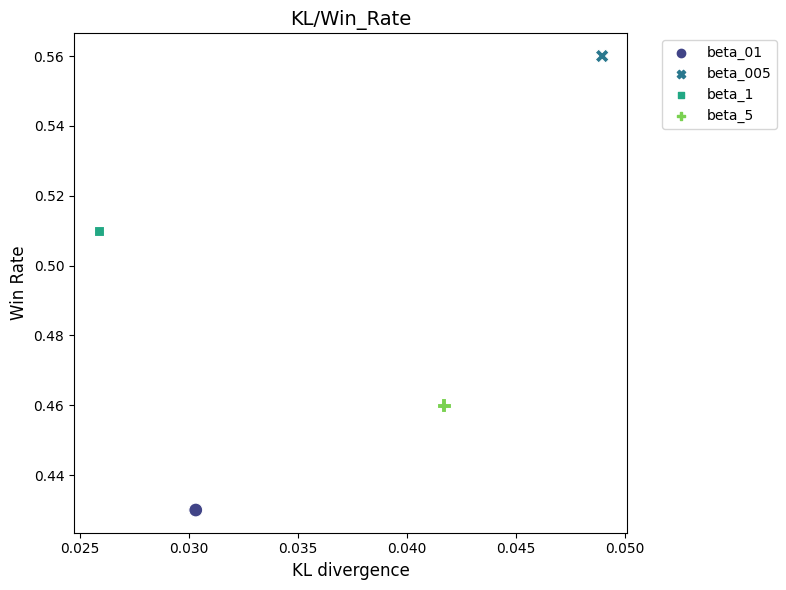

In [13]:
plt.figure(figsize=(8, 6))
scatter = sns.scatterplot(
    y=[0.43, 0.56, 0.51, 0.46],
    x=[0.030309515614999075, 0.04896892805607254, 0.025874380103271942, 0.04169781367572677],
    hue=['beta_01', 'beta_005', 'beta_1', 'beta_5'], 
    style=['beta_01', 'beta_005', 'beta_1', 'beta_5'], 
    s=100,
    palette='viridis'
)

plt.title('KL/Win_Rate', fontsize=14)
plt.xlabel('KL divergence', fontsize=12)
plt.ylabel('Win Rate', fontsize=12)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

plt.show()

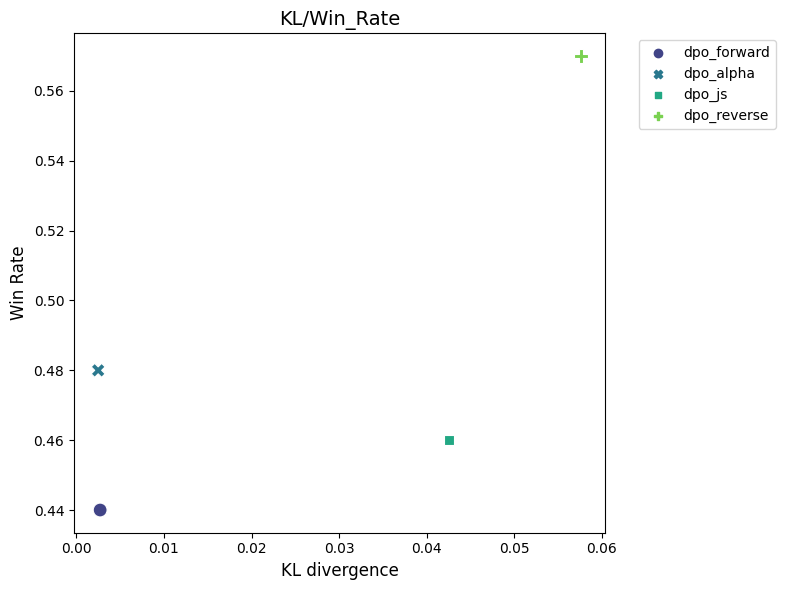

In [12]:
plt.figure(figsize=(8, 6))
scatter = sns.scatterplot(
    y=[0.44, 0.48, 0.46, 0.57],
    x=[0.002710602007052546, 0.0024853961410821208, 0.04253796548823935, 0.05763289394232595],
    hue=['dpo_forward', 'dpo_alpha', 'dpo_js', 'dpo_reverse'], 
    style=['dpo_forward', 'dpo_alpha', 'dpo_js', 'dpo_reverse'], 
    s=100,
    palette='viridis'
)

plt.title('KL/Win_Rate', fontsize=14)
plt.xlabel('KL divergence', fontsize=12)
plt.ylabel('Win Rate', fontsize=12)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

plt.show()